## Face Detection

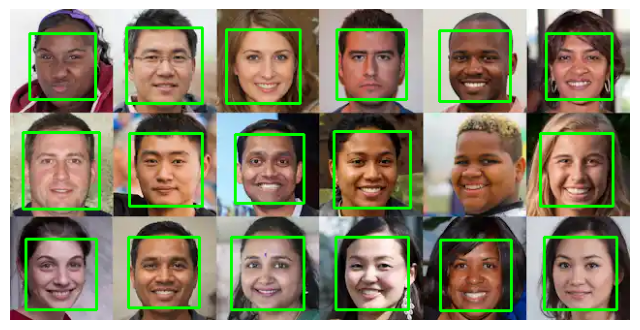

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_faces(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

image_path = "detection_data/faces2.jpeg"
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = detect_faces(gray_image)

# Draw rectangles around detected faces
for (x, y, w, h) in faces:
    # cv2.circle(image, (int(x + w/2), int(y + h/2)), int(w/2), (0, 0, 255), 4)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.show()


## Face Recognition

Loaded training data: (252, 10304)
Loaded train labels: (252,)
Loaded test data: (108, 10304)
Loaded test labels: (108,)
Shape of eigenfaces: (10304, 97)
Person unrecgonized
Probability of unrecognized: 0.14867315303220024
Person recgonized: 18
Probability of recognized: 0.27953721346994664


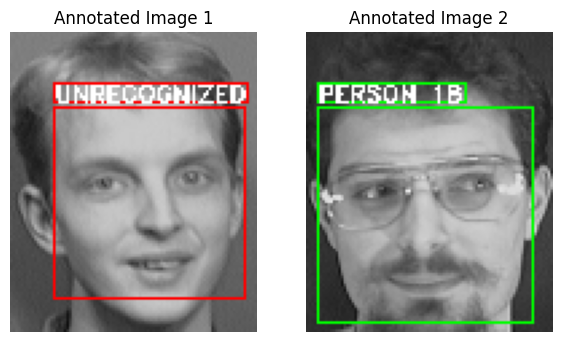

In [22]:
import numpy as np
import os
import joblib
import cv2
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img.flatten())
    return images

def prepare_training_data(data_dir='ORL', save_dir='training_data'):
    train_images = []
    train_labels = []

    for person_id in range(1, 37):
        person_folder = os.path.join(data_dir, f'p_{person_id}')
        person_images = load_images_from_folder(person_folder)[:7]  # Only the first 7 images for training
        for img in person_images:
            train_images.append(img)
            train_labels.append(person_id)

    train_images = np.array(train_images)
    train_labels = np.array(train_labels)

    print("Training data:", train_images.shape)
    print("Train labels:", train_labels.shape)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    np.save(os.path.join(save_dir, 'train_images.npy'), train_images)
    np.save(os.path.join(save_dir, 'train_labels.npy'), train_labels)

    return train_images, train_labels

def prepare_testing_data(data_dir='ORL', save_dir='testing_data'):
    test_images = []
    test_labels = []

    for person_id in range(1, 37):
        person_folder = os.path.join(data_dir, f'p_{person_id}')
        person_images = load_images_from_folder(person_folder)[7:]  # Last 3 images for testing
        for img in person_images:
            test_images.append(img)
            test_labels.append(person_id)

    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    print("Test data:", test_images.shape)
    print("Test_labels data:", test_labels.shape)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    np.save(os.path.join(save_dir, 'test_images.npy'), test_images)
    np.save(os.path.join(save_dir, 'test_labels.npy'), test_labels)

    return test_images, test_labels


def PCA(faces_data):
    # Transpose data to have (N^2 pixel, m images) shape
    data_matrix = faces_data.T
    print("Data matrix:", data_matrix.shape)

    mean_image = np.mean(data_matrix, axis=1, keepdims=True)
    print("Mean Image:", mean_image.shape)

    # Subtract mean image from all images
    centered_data = data_matrix - mean_image
    print("Centered Data:", centered_data.shape)

    # plt.imshow(mean_image.reshape(112, 92), cmap='gray')

    covariance_matrix = np.cov(centered_data.T)
    print("COV:", covariance_matrix.shape)

    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Keep all vectors summing up eigen values to 90% and remove the rest
    cumulative_variance = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)
    num_components = np.argmax(cumulative_variance >= 0.90) + 1 ## this return index of the first true 
    selected_eigenvectors = sorted_eigenvectors[:, :num_components]
    print("Selected eigvecs:", selected_eigenvectors.shape)

    # Map eigenvectors to original dimesions to come up with eigenfaces
    eigenfaces = (np.dot(selected_eigenvectors.T, centered_data.T)).T
    print("Eigen faces:", eigenfaces.shape)

    if not os.path.exists('PCA_data'):
        os.makedirs('PCA_data')

    np.save(os.path.join('PCA_data', 'centered_data.npy'), centered_data)
    np.save(os.path.join('PCA_data', 'mean_image.npy'), mean_image)
    np.save(os.path.join('PCA_data', 'eigenfaces.npy'), eigenfaces)

    return centered_data, mean_image, eigenfaces


def train_classifier(centered_data, labels, eigenfaces, saved_filename='classifier_model.pkl'):
    weight_vectors = project_on_eigenfaces(centered_data, eigenfaces)
    classifier = SVC(kernel='linear', probability=True)
    classifier.fit(weight_vectors, labels)

    # Save the trained classifier
    if not os.path.exists('ML_model'):
        os.makedirs('ML_model')
    joblib.dump(classifier, os.path.join('ML_model', saved_filename))
    
    return classifier

def evaluate_classifier(classifier, test_images, test_labels, mean_image, eigenfaces):
    test_images_centered = test_images.T - mean_image
    print("Test images centered:", test_images_centered.shape)

    weight_vecs = project_on_eigenfaces(test_images_centered, eigenfaces)
    print("Weight vectors of test images:", weight_vecs.shape)
    
    predictions = classifier.predict(weight_vecs)
    probabilities = classifier.predict_proba(weight_vecs)

    accuracy = accuracy_score(test_labels, predictions)
    print("Accuracy:", accuracy)
    
    if not os.path.exists('ML_model'):
        os.makedirs('ML_model')

    np.save(os.path.join('ML_model', 'predictions.npy'), predictions)
    np.save(os.path.join('ML_model', 'probabilities.npy'), probabilities)
    np.save(os.path.join('ML_model', 'model_accuracy.npy'), accuracy)

    return predictions, probabilities

def project_on_eigenfaces(data, eigenfaces):
    weights = np.dot(data.T, eigenfaces)
    return weights

def recognize_face(classifier, image, mean_image, eigenfaces):
    test_image = image.flatten()
    test_image_centered = test_image.reshape(-1, 1) - mean_image
    weight_vec = project_on_eigenfaces(test_image_centered, eigenfaces)
    prediction = classifier.predict_proba(weight_vec)
    return np.argmax(prediction) + 1, np.max(prediction)

def verify_recognition(classifier, image, mean_image, eigenfaces):
    MIN_MATCHING_THRESHOLD = 0.2
    result_image = image.copy()  # Make a copy of the input image

    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 and image.shape[2] == 3 else image
    gray_img = cv2.resize(gray_img, (92, 112))  # Resize for recognition

    prediction, probability = recognize_face(classifier, gray_img, mean_image, eigenfaces)

    # Detect person's face
    face = detect_faces(gray_img)

    if probability > MIN_MATCHING_THRESHOLD:
        color = (0, 255, 0)  # Green color for recognized face
        text = f"PERSON {prediction}"
        print("Person recgonized:", prediction)
        print("Probability of recognized:", probability)
    else:
        color = (255, 0, 0)  # Red color for unrecognized face
        text = "UNRECOGNIZED"
        print("Person unrecgonized")
        print("Probability of unrecognized:", probability)

    for (x, y, w, h) in face:
        text_size = 0.3
        text_offset = 2
        (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, text_size, 1)
        cv2.rectangle(result_image, (x, y - text_height - text_offset), (x + text_width, y - text_offset), color, 1)  # Thin red rectangle for unrecognized faces
        cv2.putText(result_image, text, (x, y - text_offset), cv2.QT_FONT_NORMAL, text_size, (255, 255, 255), 1)  # White text
        cv2.rectangle(result_image, (x, y), (x + w, y + h), color, 1)  # Thin rectangle around the face

    return result_image

tst_image_path_1 = 'outsiders/p_37/3.jpg'
tst_image_path_2 = 'ORL/p_18/8_001.jpg'
tst_image_1 = cv2.imread(tst_image_path_1)
tst_image_2 = cv2.imread(tst_image_path_2)

########## Omar Mohamed ##########

train_images = np.load('training_data/train_images.npy')
train_labels = np.load('training_data/train_labels.npy')

test_images = np.load('testing_data/test_images.npy')
test_labels = np.load('testing_data/test_labels.npy')

mean_image = np.load('PCA_data/mean_image.npy')
eigenfaces = np.load('PCA_data/eigenfaces.npy')

clf = joblib.load('ML_model/classifier.pkl')

# Predictions and probabilities will be used later for ROC
predictions = np.load('ML_model/predictions.npy')
probabilities = np.load('ML_model/probabilities.npy')

########## Omar Mohamed ##########

print("Loaded training data:", train_images.shape)
print("Loaded train labels:", train_labels.shape)

print("Loaded test data:", test_images.shape)
print("Loaded test labels:", test_labels.shape)

print("Shape of eigenfaces:", eigenfaces.shape)

annotated_image_1 = verify_recognition(clf, tst_image_1, mean_image, eigenfaces)
annotated_image_2 = verify_recognition(clf, tst_image_2, mean_image, eigenfaces)

plt.figure(figsize=(7,8))

plt.subplot(1, 2, 1)
plt.imshow(annotated_image_1)
plt.title("Annotated Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(annotated_image_2)
plt.title("Annotated Image 2")
plt.axis('off')
plt.show()

## Performance and ROC curves

1. Evaluating model performance

In [23]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.figure(figsize=(10, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Person')
    plt.xlabel('Predicted Person')

Accuracy: 0.9907407407407407
Precision: 0.9930555555555556
Recall: 0.9907407407407407
F1 Score: 0.9904761904761904
ROC-AUC Score: 0.9992945326278659
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15    

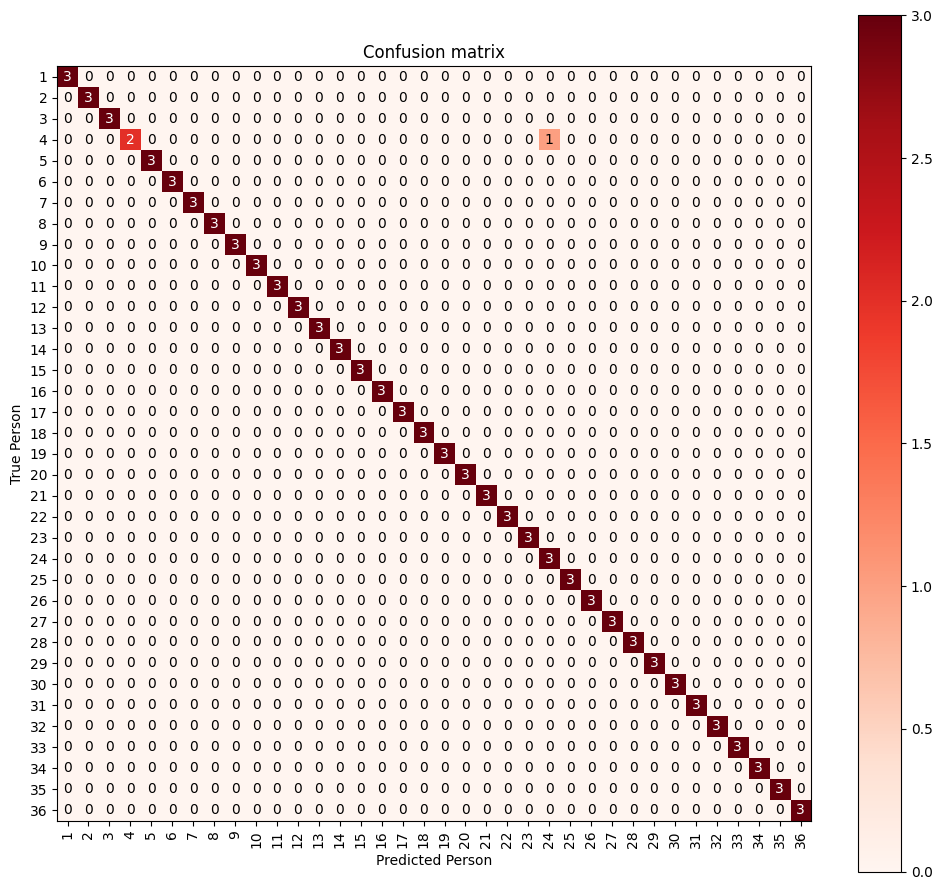

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='weighted')
recall = recall_score(test_labels, predictions, average='weighted')
f1 = f1_score(test_labels, predictions, average='weighted')
roc_auc_score = roc_auc_score(test_labels, probabilities, multi_class='ovo')


conf_matrix = confusion_matrix(test_labels, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc_score)
print("Classification Report:\n", classification_report(test_labels, predictions))
plot_confusion_matrix(conf_matrix, classes=range(1, 37))

2. Plotting ROC curves

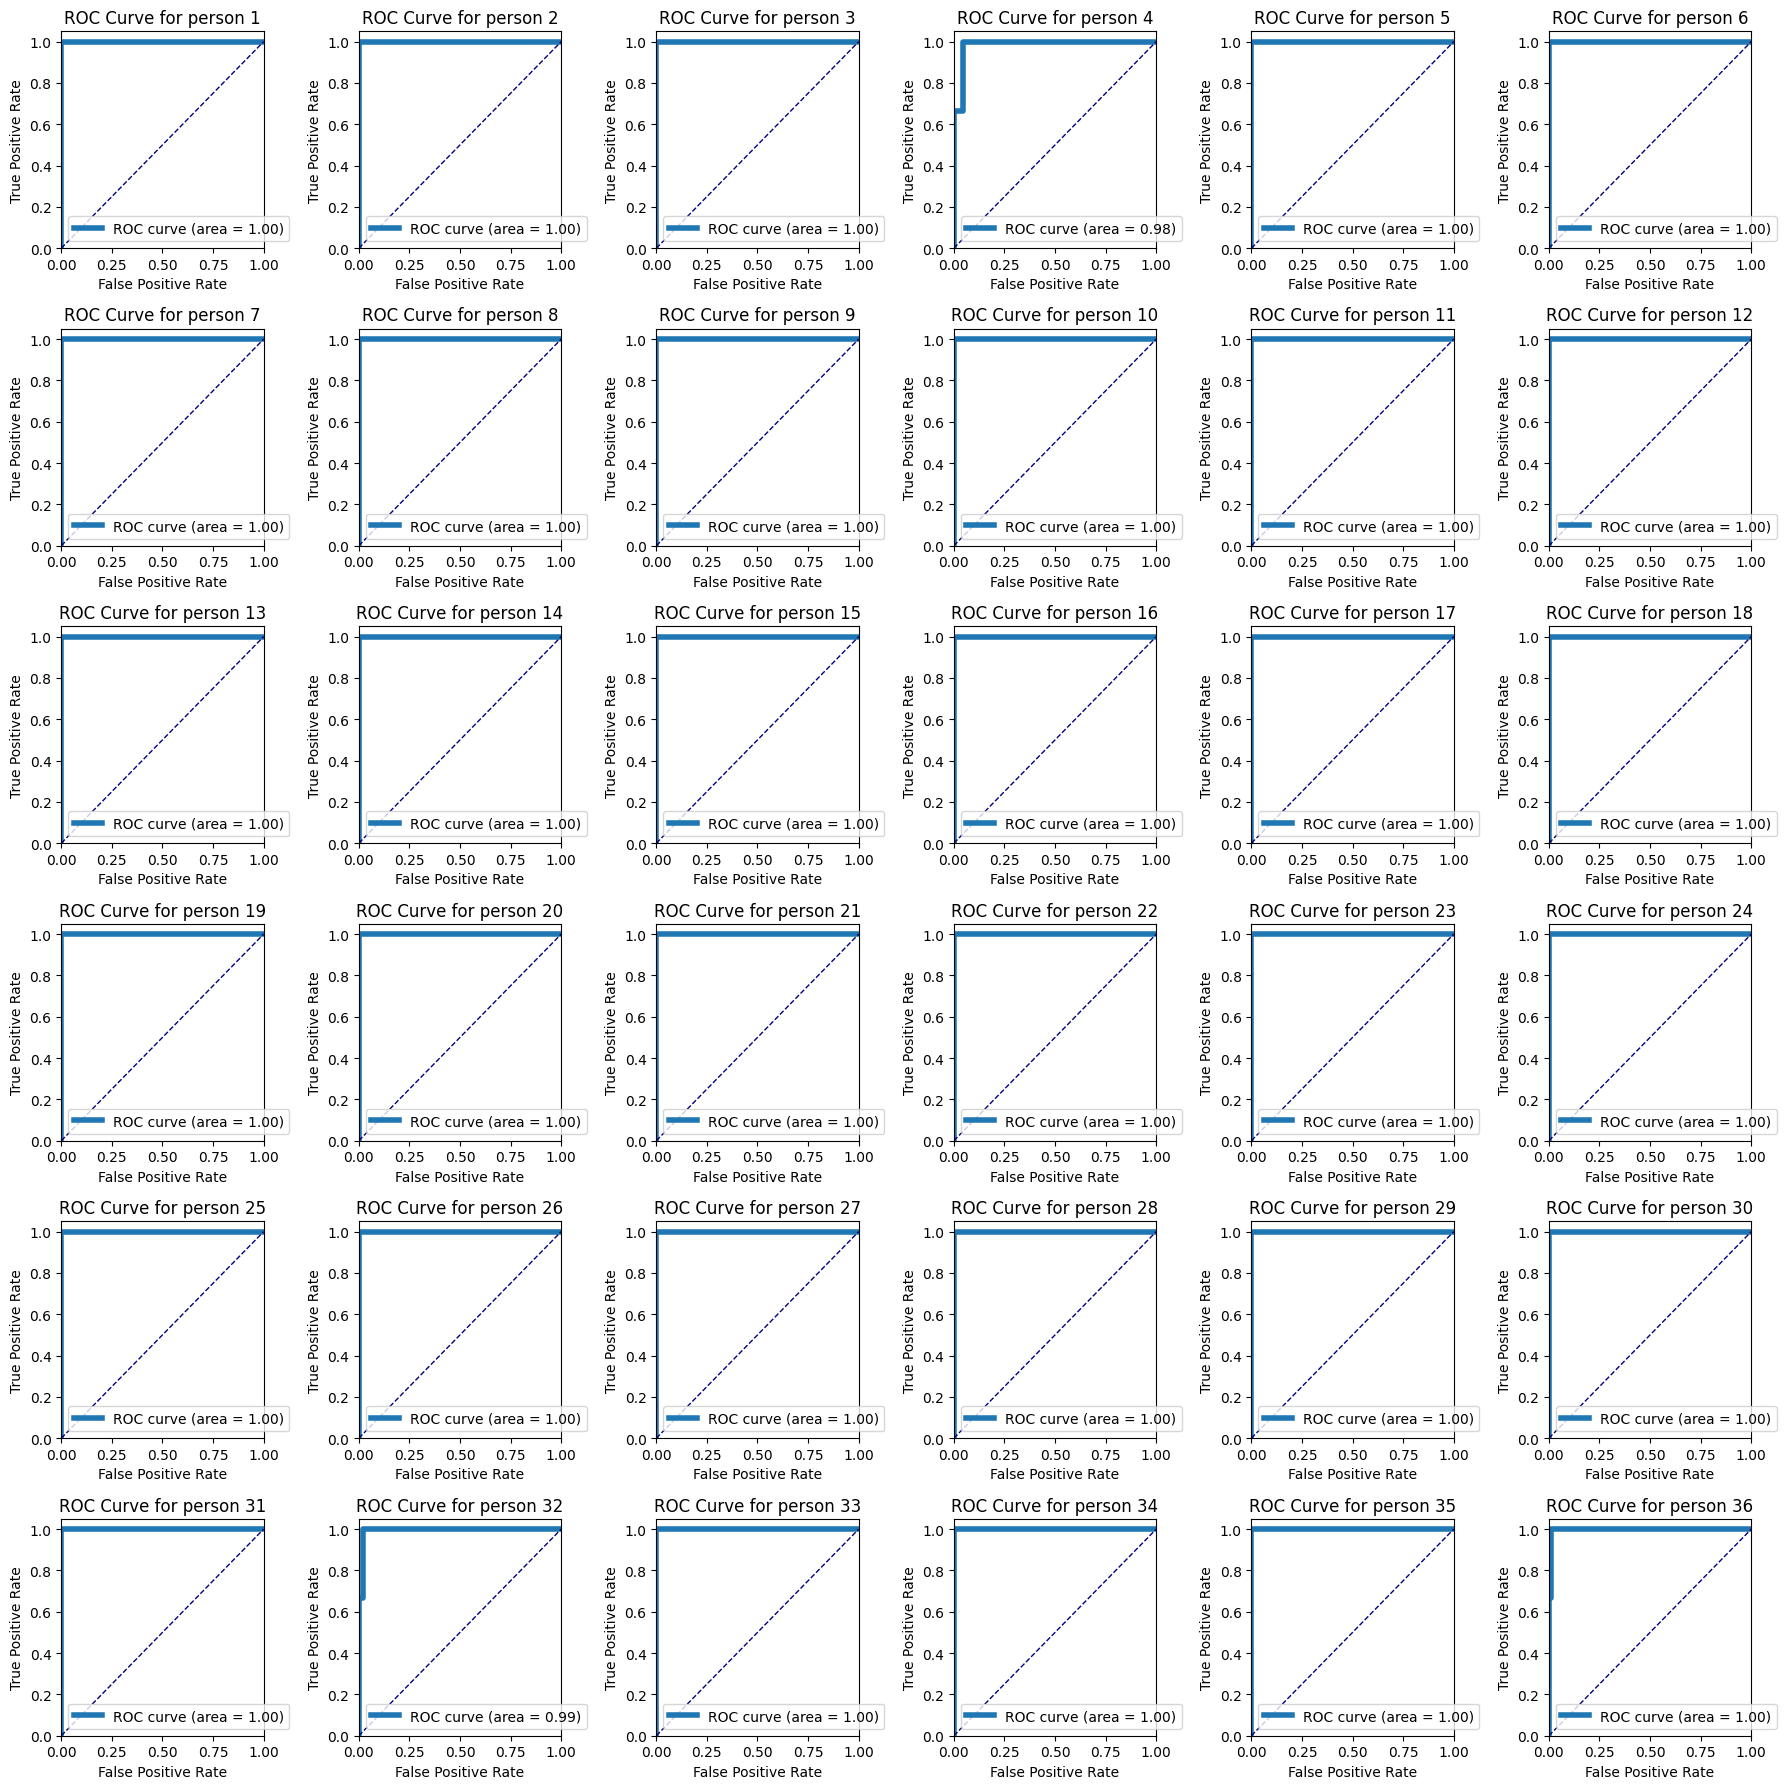

In [25]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(36):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i+1, probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
fig, axes = plt.subplots(6, 6, figsize=(18, 18))
for i, ax in enumerate(axes.flat):
    if i < 36:
        ax.plot(fpr[i], tpr[i], lw=4, label='ROC curve (area = %0.2f)' % roc_auc[i])
        ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve for person %d' % (i + 1))
        ax.legend(loc="lower left")

plt.tight_layout()
plt.show()